**Today's topics:**  
* Symbolic math in Python
* Newton's method
* Numerical derivatives

I'll put up a video on solving systems of equations

[Download on GitHub](https://github.com/NumEconCopenhagen/lectures-2021)

[<img src="https://mybinder.org/badge_logo.svg">](https://mybinder.org/v2/gh/NumEconCopenhagen/lectures-2021/master?urlpath=lab/tree/10/Solving_equations.ipynb)

1. [Solving equations by symbolic math](#Solving-equations-by-symbolic-math)
2. [Systems of linear equations](#Systems-of-linear-equations)
3. [Non-linear equations - one dimensional](#Non-linear-equations---one-dimensional)
4. [Solving non-linear equations (multi-dimensional)](#Solving-non-linear-equations-(multi-dimensional))
5. [Summary](#Summary)


# Lecture 10: Solving equations

You will learn about working with matrices and linear algebra (**scipy.linalg**), including solving systems of linear equations. You will learn to find roots of linear and non-linear equations both numerically (**scipy.optimize**) and symbolically (**sympy**).

**Note:** The algorithms written here are meant to be illustrative. The scipy implementations are always both the *fastest* and the *safest* choice.

**Links:**

1. **scipy.linalg:** [overview](https://docs.scipy.org/doc/scipy/reference/linalg.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html)
2. **sympy:** [overview](https://docs.sympy.org/latest/index.html) + [tutorial](https://docs.sympy.org/latest/tutorial/index.html#tutorial)
3. **scipy.optimize:** [overview](https://docs.scipy.org/doc/scipy/reference/optimize.html) + [turtorial](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

In [167]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import ipywidgets as widgets
import time
from scipy import linalg
from scipy import optimize
import sympy as sm
from IPython.display import display

# local module for linear algebra
%load_ext autoreload
%autoreload 2
import numecon_linalg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id="Solving-equations-by-symbolic-math"></a>

# 1. Solving equations by symbolic math

Just like your old TI calculator and Mathmatica, Python has a module for solving equations symbolically. Which also means solving them **exactly**. No numerical errors!

## 1.1 Solve consumer problem

Consider solving the following problem:

$$ 
\max_{x_1,x_2} x_1^{\alpha} x_2^{\beta} \text{ s.t. } p_1x_1 + p_2x_2 = I 
$$

Define all symbols:

In [178]:
x1 = sm.symbols('x_1') # x1 is a Python variable representing the symbol x_1
x2 = sm.symbols('x_2')
alpha = sm.symbols('alpha')
beta = sm.symbols('beta')
p1 = sm.symbols('p_1')
p2 = sm.symbols('p_2')
I = sm.symbols('I')

print('x1 is of type: ', type(x1))

x1 is of type:  <class 'sympy.core.symbol.Symbol'>


Define objective and budget constraint:

In [179]:
# Write out the equation as if it was regular code
objective = x1**alpha*x2**beta
objective

x_1**alpha*x_2**beta

In [180]:
# Define the budget constraint as an equality
budget_constraint = sm.Eq(p1*x1+p2*x2,I)
budget_constraint

Eq(p_1*x_1 + p_2*x_2, I)

Solve in **four steps**:

1. **Isolate** $x_2$ from the budget constraint
2. **Substitute** in $x_2$
3. **Take the derivative** wrt. $x_1$
4. **Solve the FOC** for $x_1$

**Step 1: Isolate**

In [181]:
# Isolate x2 on LHS
x2_from_con = sm.solve(budget_constraint, x2)
x2_from_con[0]

(I - p_1*x_1)/p_2

**Step 2: Substitute**

In [182]:
objective_subs = objective.subs(x2, x2_from_con[0])
objective_subs

x_1**alpha*((I - p_1*x_1)/p_2)**beta

**Step 3: Take the derivative**

In [183]:
foc = sm.diff(objective_subs, x1)
foc

alpha*x_1**alpha*((I - p_1*x_1)/p_2)**beta/x_1 - beta*p_1*x_1**alpha*((I - p_1*x_1)/p_2)**beta/(I - p_1*x_1)

**Step 4: Solve the FOC**

In [186]:
sol = sm.solve(sm.Eq(foc,0), x1)
sol[0]

I*alpha/(p_1*(alpha + beta))

> An alternative is `sm.solveset()`, which will be the default in the future, but it is still a bit immature in my view.

**Task:** Solve the consumer problem with quasi-linear preferences,

$$ \max_{x_1,x_2} \sqrt{x_1} + \gamma x_2 \text{ s.t. } p_1x_1 + p_2x_2 = I $$

In [ ]:
# write your code here        

In [ ]:
gamma = sm.symbols('gamma')
objective_alt = sm.sqrt(x1) + gamma*x2
objective_alt_subs = objective_alt.subs(x2,x2_from_con[0])
foc_alt = sm.diff(objective_alt_subs,x1)
sol_alt = sm.solve(foc_alt,x1)
sol_alt[0]

## 1.2 Use solution

**LaTex:** Print in LaTex format:

In [187]:
print(sm.latex(sol[0]))

\frac{I \alpha}{p_{1} \left(\alpha + \beta\right)}


### Turn solution into Python function

Sympy can do a fantastic trick!  

Once you have the solution of your equation, this can be **turned into a Python function**. Thus you can use the solution on arrays. It's called lambdification (think "lambda functions").

In [188]:
# Simple example. 1st element of lambdify: a tuple of symbols to be used. 2nd element: the expression used on the symbols.  
x = sm.symbols('x')
x_square = sm.lambdify(args = (x), expr = x**2)
x_square(12)

144

In [189]:
# Create a function out of the solution by providing the "expression" you want (ie the solution) and the inputs to the expression in a tuple. 
sol_func = sm.lambdify(args = (p1, I, alpha, beta), expr = sol[0])

# Run solution. DO NOT overwrite the SYMBOLS (I,alpha,beta) with numeric data
p1_vec = np.array([1.2,3,5,9])
I_val = 10
alpha_val = 0.5
beta_val = 0.5

# Run solution function with vector of prices
demand_p1 = sol_func(p1_vec, I_val, alpha_val, beta_val)

for d in demand_p1:
    print(f'demand: {d:1.3f}')

demand: 4.167
demand: 1.667
demand: 1.000
demand: 0.556


### Analyzing properties of the solution (expression)

**Is demand always positive?**

Give the computer the **information** we have. I.e. that $p_1$, $p_2$, $\alpha$, $\beta$, $I$ are all strictly positive:

In [190]:
for var in [p1,p2,alpha,beta,I]:
    sm.assumptions.assume.global_assumptions.add(sm.Q.positive(var)) # var is always positive
sm.assumptions.assume.global_assumptions    

{Q.positive(I),
 Q.positive(alpha),
 Q.positive(beta),
 Q.positive(p_1),
 Q.positive(p_2)}

**Ask** the computer a **question**:

In [191]:
answer = sm.ask(sm.Q.positive(sol[0]))
print(answer)

True


We need the assumption that $p_1 > 0$:

In [192]:
sm.assumptions.assume.global_assumptions.remove(sm.Q.positive(p1))
answer = sm.ask(sm.Q.positive(sol[0]))
print(answer)

None


To clear all assumptions we can use:

In [ ]:
sm.assumptions.assume.global_assumptions.clear()

## 1.3 More features of symbolic math (mixed goodies)

In [193]:
x = sm.symbols('x')

**Derivatives:** Higher order derivatives are also available

In [ ]:
sm.Derivative('x**4',x,x)

In [194]:
sm.diff('x**4',x,x)

12*x**2

Alternatively,

In [195]:
expr = sm.Derivative('x**4',x,x)
expr.doit()

12*x**2

**Integrals:**

In [196]:
sm.Integral(sm.exp(-x), (x, 0, sm.oo))

Integral(exp(-x), (x, 0, oo))

In [197]:
sm.integrate(sm.exp(-x), (x, 0, sm.oo))

1

**Limits:**

In [198]:
c = sm.symbols('c')
rho = sm.symbols('rho')
sm.Limit((c**(1-rho)-1)/(1-rho),rho,1)

Limit((c**(1 - rho) - 1)/(1 - rho), rho, 1)

In [199]:
sm.limit((c**(1-rho)-1)/(1-rho),rho,1)

log(c)

**Integers:**

In [ ]:
X = sm.Integer(7)/sm.Integer(3)
Y = sm.Integer(3)/sm.Integer(8)
display(X)
display(Y)
Z = 3
(X*Y)**Z

**Simplify:**

In [ ]:
expr = sm.sin(x)**2 + sm.cos(x)**2
display(expr)

In [ ]:
sm.simplify(expr)

**Solve multiple equations at once:**

In [ ]:
x = sm.symbols('x')
y = sm.symbols('y')
Eq1 = sm.Eq(x**2+y-2,0)
Eq2 = sm.Eq(y**2-4,0)
display(Eq1)
display(Eq2)

In [ ]:
# Solve the system
sol = sm.solve([Eq1,Eq2],[x,y])

# print all solutions
for xy in sol:
    print(f'(x,y) = ({xy[0]},{xy[1]})')

**Quizz 1**

<a id="Systems-of-linear-equations"></a>

# 2. Systems of linear equations

An economic **motivation** for solving systems of equations. 

Consider a market, where suppliers have a **supply curve**
$$
q = p/3 + 5
$$
and consumers have a **demand curve** 
$$
q = 10 - 2p
$$
This gives rise to a linear system of equations
$$
\begin{align}
q-p/3 & = 5 \\
q+2p & = 10
\end{align}
$$

When can put this into matrix notation $Ax=b$ by
$$
\begin{bmatrix} 
1 & -1/3 \\ 
1 & 2 \\
\end{bmatrix} \cdot 
\begin{bmatrix} 
q \\ 
p \\ 
\end{bmatrix} = 
\begin{bmatrix} 
10 \\ 
5 \\
\end{bmatrix}
$$
Solving for the equilibrium $x = [q, p]$ means solving $x$ in $Ax=b$.

## 2.1 Introduction

More generally, we consider **matrix equations** with $n$ equations and $n$ unknowns:

$$
\begin{aligned}
Ax = b \Leftrightarrow
\begin{bmatrix}a_{11} & a_{12} & \cdots & a_{1n}\\
a_{21} & a_{22} & \cdots & a_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}\cdot\begin{bmatrix}x_{1}\\
x_{2}\\
\vdots\\
x_{n}
\end{bmatrix} & = \begin{bmatrix}b_{1}\\
b_{2}\\
\vdots\\
b_{n}
\end{bmatrix}
\end{aligned}
$$

where $A$ is a square parameter matrix, $b$ is a parameter vector, and $x$ is the vector of unknowns.

A specific **example** could be:

$$ 
\begin{aligned}
Ax = b \Leftrightarrow
\begin{bmatrix} 
3 & 2 & 0 \\ 
1 & -1 & 0 \\
0 & 5 & 1
\end{bmatrix} \cdot
\begin{bmatrix} 
x_1 \\ 
x_2 \\
x_3
\end{bmatrix} \,=\,
\begin{bmatrix} 
2 \\ 
4 \\
-1
\end{bmatrix} 
\end{aligned}
$$

**How to solve this?**

In [244]:
A = np.array([[3.0, 2.0, 0.0], [1.0, -1.0, 0], [0.0, 5.0, 1.0]])
b = np.array([2.0, 4.0, -1.0])

Trial-and-error:

In [245]:
Ax = A@[2,-1,9] # @ is matrix multiplication
print('A@x: ',Ax)

if np.allclose(Ax,b): 
    print('solution found')
else:
    print('solution not found')

A@x:  [4. 3. 4.]
solution not found


**Various matrix operations:**

In [ ]:
A.T # transpose

In [241]:
np.diag(A) # diagonal

array([ 3., -1.,  1.])

In [242]:
np.tril(A) # lower triangular matrix

array([[ 3.,  0.,  0.],
       [ 1., -1.,  0.],
       [ 0.,  5.,  1.]])

In [243]:
np.triu(A) # upper triangular matrix

array([[ 3.,  2.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])

In [ ]:
B = A.copy()
np.fill_diagonal(B,0) # fill diagonal with zeros
print(B)

In [ ]:
linalg.inv(A) # inverse

In [ ]:
linalg.eigvals(A) # eigen values

## 2.2 Direct solution with Gauss-Jordan elimination

Consider the column stacked matrix:

$$
X=[A\,|\,b]=\begin{bmatrix}a_{11} & a_{12} & \cdots & a_{1n} & b_{1}\\
a_{21} & a_{22} & \cdots & a_{2n} & b_{2}\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn} & b_{n}
\end{bmatrix}
$$

Find the **row reduced echelon form** by performing row operations, i.e.

1. Multiply row with constant
2. Swap rows
3. Add one row to another row,

until the $A$ part of the matrix is the identity matrix.

**Manually:**

In [247]:
# a. stack
X = np.column_stack((A,b))
print('stacked:\n',X)

# b. row operations
X[0,:] += 2*X[1,:]
X[0,:] /= 5.0
X[1,:] -= X[0,:]
X[1,:] *= -1
X[2,:] -= 5*X[1,:]
print('\nrow reduced echelon form:\n',X)

# c. print result (the last column in X in row reduced echelon form)
print('\nsolution \n', X[:,-1])

stacked:
 [[ 3.  2.  0.  2.]
 [ 1. -1.  0.  4.]
 [ 0.  5.  1. -1.]]

row reduced echelon form:
 [[ 1.  0.  0.  2.]
 [-0.  1. -0. -2.]
 [ 0.  0.  1.  9.]]

solution 
 [ 2. -2.  9.]


**General function:**

In [ ]:
Y = np.column_stack((A,b))
numecon_linalg.gauss_jordan(Y)
print('solution',Y[:,-1])

which can also be used to find the inverse if we stack with the identity matrix instead,

In [248]:
# a. construct stacked matrix
Z = np.hstack((A,np.eye(3)))
print('stacked:\n',Z)

# b. apply gauss jordan elimination
numecon_linalg.gauss_jordan(Z)

# b. find inverse
inv_Z = Z[:,3:] # last 3 columns of Z in row reduced echelon form
print('inverse:\n',inv_Z)

assert np.allclose(Z[:,3:]@A,np.eye(3))

stacked:
 [[ 3.  2.  0.  1.  0.  0.]
 [ 1. -1.  0.  0.  1.  0.]
 [ 0.  5.  1.  0.  0.  1.]]
inverse:
 [[ 0.2  0.4  0. ]
 [ 0.2 -0.6  0. ]
 [-1.   3.   1. ]]


## 2.3 Iteative Gauss-Seidel (+)

We can always decompose $A$ into additive lower and upper triangular matrices,

$$
A=L+U=\begin{bmatrix}a_{11} & 0 & \cdots & 0\\
a_{21} & a_{22} & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}+\begin{bmatrix}0 & a_{12} & \cdots & a_{1n}\\
0 & 0 & \cdots & a_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & 0
\end{bmatrix}
$$

such that

$$
Ax=b\Leftrightarrow \underbrace{Lx}_{\text{LHS}}=\underbrace{b-Ux}_{\text{RHS}}
$$

The idea and beauty of the algorithm is that we go from an identity, $Ax=b$, to an iteration on $x$. This is because the $x$ on the LHS above is **not** the same $x$ as on the RHS. It is an update! And if we keep making updates, we will eventually get the solution. See how below.   

**Algorithm:** `gauss_seidel()`

1. Choose tolerance $\epsilon > 0$ and set $n=1$. Define the initial **guess** on $x$ denoted $x_0$.
2. From $A$, get $L$ and $U$ as the lower and upper part.
2. Set $\tilde{x}= x_0$
2. Given $\tilde{x}$, calculate $y_n = (b-U\tilde{x})$.
2. Given $y_n$ solve for $x_{n}$ in the equation $Lx_{n} = y_n$.
3. If $|x_{n}-\tilde{x}|_{\infty} < \epsilon$ stop.   
   Else, set $\tilde{x} = x_{n}$ and $n=n+1$ and return to step 4.

Why is this smart? Because it relies on solving a system of equations, $Lx_n=y_n$, where $L$ is **lower triangular**. It is much easier to solve a system of a lower triangular matrix, because we can use **forward substitution**.  

Consider the equation
$$
Lx = y \Leftrightarrow 
\begin{bmatrix}
a_{11} & 0 & \cdots & 0\\
a_{21} & a_{22} & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix} \cdot
\begin{bmatrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{bmatrix} 
=
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots\\
y_n \\
\end{bmatrix} 
$$

> **Note:** Solving directly by *forward substitution*:
>
> $x_1 = \frac{y_1}{a_{11}}$
>
>Using $x_1$ one can find $x_2$
>
> $x_2 = \frac{(y_2 - a_{21} x_1)}{a_{22}}$
>
> $x_3 = \frac{(y_3 - a_{31} x_1 - a_{32} x_2)}{a_{33}}$
>
> etc.

**Apply Gauss-Seidel:**

In [249]:
x0 = np.array([1,1,1])
x =  numecon_linalg.gauss_seidel(A,b,x0)
print('solution',x)

solution [ 2. -2.  9.]


> **Note:** Convergence is not ensured unless the matrix is *diagonally dominant* or *symmetric* and *positive definite*.

In [250]:
x =  numecon_linalg.gauss_seidel(A,b,x0,do_print=True)

   [1 1 1]
  0: [  0.00000000  -4.00000000  19.00000000]
  1: [  3.33333333  -0.66666667   2.33333333]
  2: [  1.11111111  -2.88888889  13.44444444]
  3: [  2.59259259  -1.40740741   6.03703704]
  4: [  1.60493827  -2.39506173  10.97530864]
  5: [  2.26337449  -1.73662551   7.68312757]
  6: [  1.82441701  -2.17558299   9.87791495]
  7: [  2.11705533  -1.88294467   8.41472337]
  8: [  1.92196312  -2.07803688   9.39018442]
  9: [  2.05202459  -1.94797541   8.73987705]
 10: [  1.96531694  -2.03468306   9.17341530]
 11: [  2.02312204  -1.97687796   8.88438980]
 12: [  1.98458531  -2.01541469   9.07707347]
 13: [  2.01027646  -1.98972354   8.94861769]
 14: [  1.99314903  -2.00685097   9.03425487]
 15: [  2.00456732  -1.99543268   8.97716342]
 16: [  1.99695512  -2.00304488   9.01522439]
 17: [  2.00202992  -1.99797008   8.98985041]
 18: [  1.99864672  -2.00135328   9.00676639]
 19: [  2.00090219  -1.99909781   8.99548907]
 20: [  1.99939854  -2.00060146   9.00300729]
 21: [  2.00040097  -1.

## 2.4 Scipy functions

**Option 1:** Use `.solve()` (scipy chooses what happens).

In [ ]:
x1 = linalg.solve(A, b)
print(x1)
assert np.all(A@x1 == b)

**Option 2:** Compute `.inv()` first and then solve.

In [251]:
Ainv = linalg.inv(A)
x2 = Ainv@b
print(x2)

[ 2. -2.  9.]


> **Note:** Computing the inverse is normally not a good idea due to numerical stability.

**Option 3:** Compute LU decomposition and then solve.

In [ ]:
LU,piv = linalg.lu_factor(A) # decomposition (factorization)
x3 = linalg.lu_solve((LU,piv),b)
print(x3)

**Detail:** `piv` contains information on a numerical stable reordering.

## 2.5 Comparisons

1. `linalg.solve()` is the best choice for solving once.
2. `linalg.lu_solve()` is the best choice when solving for multipe $b$'s for a fixed $A$ (the LU decomposition only needs to be done once).
3. Gauss-Seidel is an alternative when e.g. only an approximate solution is needed.

## 2.6 Details on LU factorization (+)

When $A$ is *regular* (invertible), we can decompose it into a *lower unit triangular matrix*, $L$, and an *upper triangular matrix*, $U$:

$$
A= \begin{bmatrix}a_{11} & a_{12} & \cdots & a_{1n}\\
a_{21} & a_{22} & \cdots & a_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix} 
= L\cdot U = \begin{bmatrix}1 & 0 & \cdots & 0\\
l_{21} & 1 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
l_{n1} & l_{n2} & \cdots & 1
\end{bmatrix}\cdot\begin{bmatrix}u_{11} & u_{12} & \cdots & u_{1n}\\
0 & u_{22} & \cdots & u_{2n}\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & u_{nn}
\end{bmatrix}
$$

where it can be shown that we can compute the elements by

$$
\begin{aligned}
\textrm{if  }\:\: i = 1 \Leftrightarrow u_{1j} &= a_{1j} \\
\textrm{else  }\:\:
u_{ij} &= a_{ij} - \sum_{k=1}^{i-1} u_{kj} l_{ik} \\
\textrm{if  }\:\: j = 1 \Leftrightarrow l_{i1} &= \frac{a_{i1}}{u_{11}} \\
\textrm{else  }\:\:
l_{ij} &= \frac{1}{u_{jj}} \big( a_{ij} - \sum_{k=1}^{j-1} u_{kj} l_{ik} \big)
\end{aligned}
$$

You can therefore get $L$ and $U$ by following steps:
* First obtain row 1 of $U$. It's equal to row 1 of $A$. 
* Then get column 1 of $L$.
* This will allow you to get $u_{2,2}$
* Based on $u_{1,2},u_{2,1},u_{2,2},l_{1,1},l_{1,2}$ you can get $l_{3,2}$.
* Keep working out subsequent $u_{ij}$ and $l_{ij}$ based on above formulas. 

The factorization implies that the equation system can be written

$$ 
Ax = L(Ux) = b 
$$

**Algorithm:** `lu_solve()`

1. Perform LU decomposition (factorization)
2. Solve $Ly = b$ for $y$ (by *forward substitution*) where $y = Ux$
3. Solve $Ux = y$ for $x$ (by *backward substitution*)

In [238]:
L,U = numecon_linalg.lu_decomposition(A) # step 1
y = numecon_linalg.solve_with_forward_substitution(L,b) # step 2
x = numecon_linalg.solve_with_backward_substitution(U,y) # step 3
print('A:\n',A)
print('L:\n',L)
print('\nU:\n',U)
print('\nsolution:',x)

A:
 [[ 3.  2.  0.]
 [ 1. -1.  0.]
 [ 0.  5.  1.]]
L:
 [[ 1.          0.          0.        ]
 [ 0.33333333  1.          0.        ]
 [ 0.         -3.          1.        ]]

U:
 [[ 3.          2.          0.        ]
 [ 0.         -1.66666667  0.        ]
 [ 0.          0.          1.        ]]

solution: [ 2. -2.  9.]


**Relation to scipy:**

1. Scipy use pivoting to improve numerical stability.
2. Scipy is implemented much much better than here.

## 2.7 Sparse matrices (+)

**Sparse matrix:** A matrix with many zeros. Letting the computer know where they are is extremely valuable.

**Documentation:** [basics](https://docs.scipy.org/doc/scipy/reference/sparse.html) + [linear algebra](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#module-scipy.sparse.linalg)

**Create a sparse matrix**, where most elements are on the diagonal:

In [252]:
from scipy import sparse
import scipy.sparse.linalg

S = sparse.lil_matrix((1000, 1000)) # 1000x1000 matrix with zeroes
S.setdiag(np.random.rand(1000)) # some values on the diagonal
S[200, :100] = np.random.rand(100) # some values in a row
S[200:210, 100:200] = S[200, :100] # and the same value in some other rows

Create a plot of the values in the matrix:

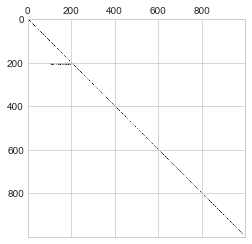

In [253]:
S_np = S.toarray() # conversion to numpy
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.matshow(S_np,cmap=plt.cm.binary);

**Solve it in four different ways:**

1. Like it was not sparse
2. Using the sparsity
3. Using the sparsity + explicit factorization
4. Iterative solver (similar to Gauss-Seidel)

In [ ]:
k = np.random.rand(1000) # random RHS

# a. solve
t0 = time.time()
x = linalg.solve(S_np,k)
print(f'{"solve":12s}: {time.time()-t0:.5f} secs')

# b. solve with spsolve
t0 = time.time()
x_alt = sparse.linalg.spsolve(S.tocsr(), k)
print(f'{"spsolve":12s}: {time.time()-t0:.5f} secs')
assert np.allclose(x,x_alt)
      
# c. solve with explicit factorization
t0 = time.time()
S_solver = sparse.linalg.factorized(S.tocsc())
x_alt = S_solver(k)
print(f'{"factorized":12s}: {time.time()-t0:.5f} secs')
assert np.allclose(x,x_alt)
      
# d. solve with iterative solver (bicgstab)
t0 = time.time()
x_alt,_info = sparse.linalg.bicgstab(S,k,x0=1.001*x,tol=10**(-8))
print(f'{"bicgstab":12s}: {time.time()-t0:.5f} secs')
assert np.allclose(x,x_alt),x-x_alt

**Conclusion:** 

1. Using the sparsity can be very important.
2. Iterative solvers can be very very slow.

## 2.8 Solving matrix equations symbolically (+)

$$ Ax = b $$

**Remember:**

In [ ]:
print('A:\n',A)
print('b:',b)

**Construct symbolic matrix:**

In [254]:
A_sm = numecon_linalg.construct_sympy_matrix(['11','12','21','22','32','33']) # somewhat complicated function
A_sm

Matrix([
[a_11, a_12,    0],
[a_21, a_22,    0],
[   0, a_32, a_33]])

**Find the inverse symbolically:**

In [255]:
A_sm_inv = A_sm.inv()
A_sm_inv

Matrix([
[               a_22/(a_11*a_22 - a_12*a_21),                -a_12/(a_11*a_22 - a_12*a_21),      0],
[              -a_21/(a_11*a_22 - a_12*a_21),                 a_11/(a_11*a_22 - a_12*a_21),      0],
[a_21*a_32/(a_11*a_22*a_33 - a_12*a_21*a_33), -a_11*a_32/(a_11*a_22*a_33 - a_12*a_21*a_33), 1/a_33]])

**Fill in the numeric values:**

In [ ]:
A_inv_num = numecon_linalg.fill_sympy_matrix(A_sm_inv,A) # somewhat complicated function
x = A_inv_num@b
print('solution:',x)

**Note:** The inverse multiplied by the determinant looks nicer...

In [256]:
A_sm_det = A_sm.det()
A_sm_det

a_11*a_22*a_33 - a_12*a_21*a_33

In [257]:
A_sm_inv_raw = sm.simplify(A_sm_inv*A_sm_det)
A_sm_inv_raw

Matrix([
[ a_22*a_33, -a_12*a_33,                     0],
[-a_21*a_33,  a_11*a_33,                     0],
[ a_21*a_32, -a_11*a_32, a_11*a_22 - a_12*a_21]])

<a id="Non-linear-equations---one-dimensional"></a>

# 3. Non-linear equations - one dimensional

## 3.1 Introduction

We often want to **solve non-linear equations** on the form,

$$ 
f(x) = 0, x \in \mathbb{R} 
$$

This is also called **root-finding**. In economics, we really like setting **First Order Conditions** to 0. Thus, we want to do root finding. 

A simple **example** of a function for our root finding:

$$
f(x) = -x^3 + 2x^2 + 4x + 30 
$$

## 3.2 Derivative based methods

**Newton methods:** Assume you know the function value and derivatives at $x_0$. 

A **first order** Taylor approximation of the function at $x_k$ is:

$$ 
f(x_k) \approx f(x_0) + f^{\prime}(x_0)(x_k-x_0)
$$

implying 

$$
f(x_k) = 0 \Leftrightarrow x_k = x_0 - \frac{f(x_0)}{f^{\prime}(x_0)}
$$

This is called **Newton's method**.   

You can think of it as an **operator** on $x$ with respect to $f$ used to find the **nearest** root of $f$.  

Let's call the operator $\mathcal{N}_f$. If our current guess of a root to $f$ is $x_k$, we can get a new guess $x_{k+1}$ by applying $\mathcal{N}_f(x_k)$
* $x_1 = \mathcal{N}_f(x_0) =  x_0 - \frac{f(x_0)}{f^{\prime}(x_0)}$
* $x_2 = \mathcal{N}_f(x_1)$
* $x_3 = \mathcal{N}_f(x_2)$
* ...

We have found a root when $|f(x_{k})| < \epsilon$ which implies that the consecutive guesses also will become very close: $|x_{k+1}-x_k| < \epsilon'$.

An alternative is **Halleys method** (see [derivation](https://mathworld.wolfram.com/HalleysMethod.html)), which uses

$$
x_k = x_0 - \frac{f(x_0)}{f^{\prime}(x_0)} \Big[ 1-\frac{f(x_0)}{f^{\prime}(x_0)}\frac{f^{\prime\prime}(x_0)}{2f^{\prime}(x_0)} \Big]^{-1} := \mathcal{H}_f(x_0)
$$

making use of information from the **second derivative**. Note that if the second derivative is close to 0, Halley's method collapses into Newton's.  

We denote this operator by $\mathcal{H}_f(x_k)$


**Algorithm:** `find_root()`

1. Choose tolerance $\epsilon > 0$, guess on $x_0$ and set $k = 0$.
2. Calculate $f(x_k)$ and $f^{\prime}(x_k)$. Also calculate $f^{\prime\prime}(x_k)$ when using Halley's method.
3. If $|f(x_k)| < \epsilon$ then stop.
4. Calculate new candidate $x_{k+1} = \mathcal{N}_f(x_k)$ when using Newtons.  
   Otherwise, calculate $x_{k+1} = \mathcal{H}_f(x_k)$ when using Halleys formula.
5. Set $k = k + 1$ and return to step 2.

In [200]:
def find_root(x0,f,df,d2f=None,method='newton',max_iter=500,tol=1e-8,full_info=False):
    """ find root
        
    Args:
    
        x0 (float): initial value
        f (callable): function
        df (callable): derivative
        d2f (callable): second derivative
        method (str): newton or halley
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        full_info (bool): controls information returned
        
    Returns:
    
        x (float/ndarray): root (if full_info, all x tried)
        i (int): number of iterations used
        fx (ndarray): function values used (if full_info) 
        fpx (ndarray): derivative values used (if full_info)
        fppx (ndarray): second derivative values used (if full_info)
        
    """
    
    # initialize
    xs = []
    fxs = []
    dfxs = []
    d2fxs = []
    
    # iterate
    x = x0    
    i = 0    
    while True:
        
        # step 2: evaluate function and derivatives
        fx = f(x)
        dfx = df(x)
        if method == 'halley':
            d2fx = d2f(x)
        
        # step 3: check convergence
        if abs(fx) < tol or i >= max_iter:
            break
            
        # step 4: update x
        if method == 'newton':
            x_k = x - fx/dfx
        elif method == 'halley':
            a = fx/dfx
            b = a*d2fx/(2*dfx)
            x_k = x - a/(1-b)
        
        # step 5: increment counter
        i += 1
        
        # step 6: store history
        xs.append(x)
        fxs.append(fx)
        dfxs.append(dfx)
        if method == 'halley':
            d2fxs.append(d2fx)
        
        # step 7: apply new guess for x
        x = x_k
        
    # return
    if full_info:
        return np.array(xs),i,np.array(fxs),np.array(dfxs),np.array(d2fxs)
    else:
        return x,i

**Note:** The cell below contains a function for plotting the convergence.

In [201]:
def plot_find_root(x0,f,fp,fpp=None,method='newton',xmin=-8,xmax=8,xn=100, vline = False):
    
    # a. find root and return all information 
    x,max_iter,fx,fpx,fppx = find_root(x0,f,df=fp,d2f=fpp,method=method,full_info=True)
    
    # b. compute function on grid
    xvec = np.linspace(xmin,xmax,xn)
    fxvec = f(xvec)
    
    # c. figure
    def _figure(i):
        
        # i. approximation
        if method == 'newton':
            fapprox = fx[i] + fpx[i]*(xvec-x[i])
        elif method == 'halley':
            fapprox = fx[i] + fpx[i]*(xvec-x[i]) + fppx[i]/2*(xvec-x[i])**2  
            
        # ii. figure
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(xvec,fxvec,label='function') # on grid
        ax.plot(x[i],0,'o',color='blue',mfc='none',label='$x_{k}$')# now
        ax.plot(x[i],fx[i],'o',color='black',label='$f(x_k)$') # now       
        ax.plot(xvec,fapprox,label='approximation') # approximation
        
        if vline:
            ax.axvline(x[i+1],ls='--',lw=1,color='black') # cross zero
        
        ax.axvline(0,ls='-',lw=1,color='black') # cross zero
        ax.axhline(0, ls='-',lw=1,color='black')
        #ax.plot(x[i+1],fx[i+1],'o',color='black',mfc='none',label='next')# next
        ax.plot(x[i+1],0,'o',color='green',mfc='none',label='$x_{k+1}$')# next
            
        ax.legend(loc='lower right',facecolor='white',frameon=True)
        ax.set_ylim([fxvec[0],fxvec[-1]])
    
    widgets.interact(_figure,
        i=widgets.IntSlider(description="iterations", min=0, max=max_iter-2, step=1, value=0)
    );

## 3.3 Example

In [202]:
# Another use case of our symbolic math
x = sm.symbols('x')
func = -x**3 + 2*x**2 + 4*x + 30
dfunc = sm.diff(func, x)
d2func = sm.diff(dfunc, x)

display(func)
display(dfunc)
display(d2func)

-x**3 + 2*x**2 + 4*x + 30

-3*x**2 + 4*x + 4

4 - 6*x

In [203]:
# Lambdify
f = sm.lambdify((x), func)
df = sm.lambdify((x), dfunc)
d2f = sm.lambdify((x), d2func)

In [204]:
x, i = find_root(-2,f,df,method='newton', full_info=False)
print(f'Iterations: {i}, root = {x}')

Iterations: 26, root = 4.430847399984182


Notice how the **flat region** tricks both Newton's and Halley's methods.  
Especially Halley's method does better if it is started to the right of the root rather than to the left. 

In [212]:
plot_find_root(8,f,df,method='newton')

interactive(children=(IntSlider(value=0, description='iterations', max=4), Output()), _dom_classes=('widget-in…

In [209]:
x,i = find_root(-5,f,df,d2f,method='halley')
print(i,x,f(x))

22 4.43084739997514 3.361044775829214e-10


In [213]:
plot_find_root(-2,f,df,d2f,method='halley', vline='True')

interactive(children=(IntSlider(value=0, description='iterations', max=24), Output()), _dom_classes=('widget-i…

## 3.4 Numerical derivative

Sometimes, you might not have the **analytical derivative**. Then, you can instead use the **numerical derivative**.

**Numerical derivative**  
Define $\Delta$ to be a small number, then we approximate the derivative by 
$$
 \frac{df}{dx} \approx \frac{f(x+\Delta) - f(x)}{\Delta}
$$

In [220]:
# a. function
#f = lambda x: 10*x**3 - x**2 -1

# b. numerical derivative (forward)
#Δ = 1e-8
Δ = 10.5
fp_approx = lambda x: (f(x+Δ)-f(x))/Δ

# b. find root
x0 = -1.5
x,i = find_root(x0,f,fp_approx,method='newton')
print(f'iterations: {i}, root: {x}, f(x) = {f(x)}')

iterations: 165, root: 4.430847399745889, f(x) = 8.858261679733914e-09


**Question:** What happens if you increase the stepsize?   
**Quiz 2**

## 3.5 Another example

In [223]:
g = lambda x: np.sin(x)
gp = lambda x: np.cos(x)
gpp = lambda x: -np.sin(x)

x0 = 4.0
plot_find_root(x0,g,gp,gpp,method='newton')

interactive(children=(IntSlider(value=0, description='iterations', max=2), Output()), _dom_classes=('widget-in…

**Question:** Is the initial value important?

**Sympy** can actually tell us that there are many solutions:

In [224]:
x = sm.symbols('x')
sm.solveset(sm.sin(x),)

Union(ImageSet(Lambda(_n, 2*_n*pi + pi), Integers), ImageSet(Lambda(_n, 2*_n*pi), Integers))

## 3.6 Derivative free methods: Bisection

**Algorithm:** `bisection()`

1. Set $a_0 = a$ and $b_0 = b$ where $f(a)$ and $f(b)$ has oposite sign, $f(a_0)f(b_0)<0$
2. Compute $f(m_0)$ where $m_0 = (a_0 + b_0)/2$ is the midpoint.
3. Determine the next sub-interval $[a_1,b_1]$:
  * If $f(a_0)f(m_0) < 0$ (different signs) then $a_1 = a_0$ and $b_1 = m_0$ (i.e. focus on the range $[a_0,m_0]$).
  * If $f(m_0)f(b_0) < 0$ (different signs) then $a_1 = m_0$ and $b_1 = b_0$ (i.e. focus on the range $[m_0,b_0]$).
4. Repeat step 2 and step 3 until $f(m_n) < \epsilon$.

In [225]:
def bisection(f,a,b,max_iter=500,tol=1e-6,full_info=False):
    """ bisection
    
    Solve equation f(x) = 0 for a <= x <= b.
    
    Args:
    
        f (callable): function
        a (float): left bound
        b (float): right bound
        max_iter (int): maximum number of iterations
        tol (float): tolerance on solution
        full_info (bool): controls information returned
        
    Returns:
    
        m (float/ndarray): root (if full_info, all x tried)
        i (int): number of iterations used
        a (ndarray): left bounds used
        b (ndarray): right bounds used
        fm (ndarray): funciton values at midpoints
        
    """
    
    # test inputs
    if f(a)*f(b) >= 0:
        print("bisection method fails.")
        return None
    
    # step 1: initialize
    a_l = []
    b_l = []
    m_l = []
    fm_l = []
    
    # step 2-4: main
    i = 0
    while i < max_iter:
        
        # step 2: midpoint and associated value
        m = (a+b)/2
        fm = f(m)
        
        # substep: update the lists of history 
        a_l.append(a)
        b_l.append(b)
        m_l.append(m)
        fm_l.append(fm)
        
        # step 3: determine sub-interval
        if abs(fm) < tol:
            break        
        elif f(a)*fm < 0:
            b = m
        elif f(b)*fm < 0:
            a = m
        else:
            print("bisection method fails.")
            return None
        
        i += 1
        
    if full_info:
        # Returned lists are converted to np.arrays for good measure
        return np.array(m_l), i, np.array(a_l), np.array(b_l), np.array(fm_l)
    else:
        return m,i

**Same result** as before, but **trade-off** between more iterations and no evaluation of derivatives.

In [228]:
m,i = bisection(f,2,7)
print(i,m,f(m))

26 4.4308473989367485 3.8937109536618664e-08


**Note:** The cell below contains a function for plotting the convergence.

In [231]:
def plot_bisection(f,a,b,xmin=-8,xmax=8,xn=100):
    
    # a. find root and return all information 
    res = bisection(f,a,b,full_info=True)
    if res == None:
        return
    else:
        m,max_iter,a,b,fm = res
    
    # b. compute function on grid
    xvec = np.linspace(xmin,xmax,xn)
    fxvec = f(xvec)
    
    # c. figure
    def _figure(i):
        
        # ii. figure
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(xvec,fxvec) # on grid
        ax.plot(m[i],fm[i],'o',color='black',label='current') # mid
        ax.plot([a[i],b[i]],[fm[i],fm[i]],'--',color='black',label='range') # range
        ax.axvline(a[i],ls='--',color='black')
        ax.axvline(b[i],ls='--',color='black')        
        
        ax.legend(loc='lower right',facecolor='white',frameon=True)
        ax.set_ylim([fxvec[0],fxvec[-1]])
    
    widgets.interact(_figure,
        i=widgets.IntSlider(description="iterations", min=0, max=max_iter-1, step=1, value=0)
    );

plot_bisection(f,-8,8)

interactive(children=(IntSlider(value=0, description='iterations', max=24), Output()), _dom_classes=('widget-i…

**Quiz 4**

**Note:** Bisection is not good at the final convergence steps. Generally true for methods not using derivatives.

## 3.7 Scipy

Scipy, naturally, has better implementations of the above algorithms.

**Newton:**

In [233]:
result = optimize.root_scalar(f,x0=-4,fprime=df,method='newton')
print(result)

      converged: True
           flag: 'converged'
 function_calls: 32
     iterations: 16
           root: 4.430847399984182


**Halley:**

In [ ]:
result = optimize.root_scalar(f,x0=-4,fprime=fp,fprime2=fpp,method='halley')
print(result)

**Bisect:**

In [234]:
result = optimize.root_scalar(f,bracket=[-8,7],method='bisect')
print(result)

      converged: True
           flag: 'converged'
 function_calls: 45
     iterations: 43
           root: 4.430847399984373


The **best choice** is the more advanced **Brent-method**:

In [ ]:
result = optimize.root_scalar(f,bracket=[-8,7],method='brentq')
print(result)

<a id="Solving-non-linear-equations-(multi-dimensional)"></a>

# 4. Solving non-linear equations (multi-dimensional)

## 4.1 Introduction

We consider **solving non-linear equations** on the form,

$$ 
f(\boldsymbol{x}) = f(x_1,x_2,\dots,x_k) = \boldsymbol{0}, \boldsymbol{x} \in \mathbb{R}^k
$$

A specific **example** is:

$$ 
h(\boldsymbol{x})=h(x_{1,}x_{2})=\begin{bmatrix}h_{1}(x_{1},x_{2})\\
h_{2}(x_{1},x_{2})
\end{bmatrix}=\begin{bmatrix}x_{1}+0.5(x_{1}-x_{2})^{3}-1\\
x_{2}+0.5(x_{1}-x_{2})^{3}
\end{bmatrix}\in\mathbb{R}^{2} 
$$

where the **Jacobian** is

$$ 
\nabla h(\boldsymbol{x})=\begin{bmatrix}\frac{\partial h_{1}}{\partial x_{1}} & \frac{\partial h_{1}}{\partial x_{2}}\\
\frac{\partial h_{2}}{\partial x_{1}} & \frac{\partial h_{2}}{\partial x_{2}}
\end{bmatrix}=\begin{bmatrix}1+1.5(x_{1}-x_{2})^{2} & -1.5(x_{1}-x_{2})^{2}\\
-1.5(x_{2}-x_{1})^{2} & 1+1.5(x_{2}-x_{1})^{2}
\end{bmatrix}
$$

In [ ]:
def h(x):
    y = np.zeros(2)
    y[0] = x[0]+0.5*(x[0]-x[1])**3-1.0
    y[1] = x[1]+0.5*(x[1]-x[0])**3
    return y

def hp(x):
    y = np.zeros((2,2))
    y[0,0] = 1+1.5*(x[0]-x[1])**2
    y[0,1] = -1.5*(x[0]-x[1])**2
    y[1,0] = -1.5*(x[1]-x[0])**2
    y[1,1] = 1+1.5*(x[1]-x[0])**2
    return y

## 4.2 Newton's method

Same as Newton's method in one dimension, but with the following **update step**:

$$ 
\boldsymbol{x}_{n+1} = \boldsymbol{x_n} - [ \nabla h(\boldsymbol{x_n})]^{-1} f(\boldsymbol{x_n})
$$

In [ ]:
def find_root_multidim(x0,f,fp,max_iter=500,tol=1e-8):
    """ find root
        
    Args:
    
        x0 (float): initial value
        f (callable): function
        fp (callable): derivative
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        
    Returns:
    
        x (float): root
        i (int): number of iterations used
        
    """
    
    # initialize
    x = x0
    i = 0
    
    # iterate
    while i < max_iter:
        
        # step 2: function and derivatives
        fx = f(x)
        fpx = fp(x)
        
        # step 3: check convergence
        if max(abs(fx)) < tol:
            break
            
        # step 4: update x
        fpx_inv = linalg.inv(fpx)        
        x = x - fpx_inv@fx
        
        # step 5: increment counter
        i += 1
        
    return x,i

**Test algorithm:**

In [ ]:
x0 = np.array([0,0])
x,i = find_root_multidim(x0,h,hp)
print(i,x,h(x))

## 4.3 Using Scipy

You should use profesionally implemented routines for optimizing your models!   
There exist a lot of efficient algorithms for finding roots in multiple dimensions. The default **scipy** choice is something called ***hybr***.

**With the Jacobian:**

In [ ]:
result = optimize.root(h,x0,jac=hp)
print(result)
print('\nx =',result.x,', h(x) =',h(result.x))

**Without the Jacobian:** (numerical derivative)

In [ ]:
result = optimize.root(h,x0)
print(result)
print('\nx =',result.x,', h(x) =',h(result.x))

<a id="Summary"></a>

# 5. Summary

**This lecture:**

1. Solving matrix equations (directly, decomposition, iterative)
2. Symbollic solutions (substitution, derivative, solution)
3. Root-finding (one dimension, multiple dimensions, Newton's method, biscetion)

**Your work:** Play around with the code in this notebook before solving the problem set. Especially, try out the various scipy functions used.

**Next lecture:** Numerical optimization.